## Introduction

This notebook contains the code for the Week 3 assignment. The assignment involves K-Nearest Neighbors classification model to predict whether an individual earns a low income (≤50K) or high income (>50K) using the Adult-all dataset. Our goal is to understand the key factors driving income disparity in the U.S. by leveraging a cleaned and encoded dataset, identifying influential features, and evaluating model performance.

# Import Libraries
We import essential Python libraries to support the entire modeling process. This includes tools for data manipulation (pandas, numpy), preprocessing (encoding, scaling, imputation), KNN modeling (scikit-learn), evaluation (accuracy, classification metrics), and visualization (matplotlib). This sets up the foundation for loading, processing, and analyzing the Adult dataset to predict income levels.

In [1]:
# Import necessary libraries for data manipulation, preprocessing, modeling, and visualization
import pandas as pd                          # For data manipulation and DataFrame operations
import numpy as np                           # For numerical operations and array handling
from sklearn.model_selection import train_test_split  # To split data into training and test sets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler  # For encoding and scaling
from sklearn.impute import SimpleImputer     # For imputing missing values
from sklearn.neighbors import KNeighborsClassifier  # KNN model for classification
from sklearn.metrics import accuracy_score, classification_report  # For model evaluation
from sklearn.model_selection import cross_val_score  # For cross-validation to tune K
from sklearn.inspection import permutation_importance  # To assess feature importance via permutation
import matplotlib.pyplot as plt              # For plotting results (e.g., accuracy vs. K, feature importance)

# Load and Clean Data
We load the Adult dataset from 'adult-all.csv' and clean it to ensure high-quality input for modeling. We replace missing value indicators ('?') with NaN, drop rows with missing 'income' (target), remove duplicates, and impute missing values in features—using mode for categorical columns and median for numeric ones. This prepares a complete, unique dataset for accurate income classification.

In [2]:
# Load the dataset from a CSV file named 'adult-all.csv' into a pandas DataFrame
data = pd.read_csv('adult-all.csv')          # Assumes 'adult-all.csv' is in the working directory

# Replace all '?' (missing value indicator in Adult dataset) with NaN for easier handling
data.replace('?', np.nan, inplace=True)      # Converts '?' to NaN across all columns

# Print the number of missing values in the 'income' column to check for NaN
print("Missing values in 'income':", data['income'].isnull().sum())  # Identifies NaN in target

# Display the count of each unique value in 'income', including NaN, to understand distribution
print(data['income'].value_counts(dropna=False))  # Shows <=50K, >50K, and NaN counts

# Drop rows where 'income' is NaN since it’s the target variable and must be complete
data = data.dropna(subset=['income'])        # Removes rows with missing target to ensure valid labels

# Print the shape of the dataset after dropping NaN in 'income' to track row reduction
print(f"Dataset shape after dropping NaN in 'income': {data.shape}")  # Tracks row count reduction

# Remove duplicate rows to ensure each observation is unique and avoid bias in modeling
data.drop_duplicates(inplace=True)           # Drops identical rows to prevent overfitting

# Print the shape after dropping duplicates to see if any were removed
print(f"Dataset shape after removing duplicates: {data.shape}")  # Confirms final row count

# Show the updated distribution of 'income' to confirm the target variable’s balance
print(data['income'].value_counts())         # Verifies <=50K vs. >50K distribution post-cleansing

# Define lists of categorical and numeric column names based on the Adult dataset structure
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']  # Categorical features to encode
numeric_cols = ['Age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']  # Numeric features

# Create an imputer for categorical columns, filling NaN with the most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode imputation for categorical data

# Create an imputer for numeric columns, filling NaN with the median (robust to outliers)
num_imputer = SimpleImputer(strategy='median')  # Median imputation for numeric data

# Apply the categorical imputer to fill missing values in categorical columns
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])  # Fills NaN with mode

# Apply the numeric imputer to fill missing values in numeric columns
data[numeric_cols] = num_imputer.fit_transform(data[numeric_cols])  # Fills NaN with median

Missing values in 'income': 0
income
<=50K    37155
>50K     11687
Name: count, dtype: int64
Dataset shape after dropping NaN in 'income': (48842, 15)
Dataset shape after removing duplicates: (48790, 15)
income
<=50K    37109
>50K     11681
Name: count, dtype: int64


# Encode Categorical Data

Transforms categorical data into a numeric format suitable for KNN. We use LabelEncoder to convert the binary 'income' target into 0 and 1, and OneHotEncoder to expand categorical features into binary columns, dropping the first category to avoid redundancy. The encoded features are then combined with numeric columns, creating a fully numeric dataset.

In [3]:
# Initialize a LabelEncoder to convert the binary 'income' target into numeric (0 and 1)
le = LabelEncoder()                          # Creates encoder for binary target transformation

# Encode 'income' where 'small' becomes 0 and 'large' becomes 1 (assuming <=50K and >50K)
data['income'] = le.fit_transform(data['income'])  # Transforms <=50K to 0, >50K to 1

# Initialize a OneHotEncoder for categorical features, dropping the first category to avoid multicollinearity
ohe = OneHotEncoder(sparse=False, drop='first')  # One-hot encoder, dense output, drops first category

# Transform categorical columns into one-hot encoded format, creating binary columns
encoded_cats = pd.DataFrame(ohe.fit_transform(data[categorical_cols]), 
                            columns=ohe.get_feature_names_out(categorical_cols))  # Converts categories to binary columns

# Reset the index of the original DataFrame to ensure alignment after row drops
data.reset_index(drop=True, inplace=True)    # Resets index to avoid misalignment with encoded data

# Reset the index of the encoded categorical DataFrame to match the main DataFrame
encoded_cats.reset_index(drop=True, inplace=True)  # Ensures encoded data aligns with main DataFrame

# Combine numeric columns and 'income' with the one-hot encoded categorical columns
data = pd.concat([data[numeric_cols + ['income']], encoded_cats], axis=1)  # Merges all features and target

# Print the shape of the dataset after encoding to verify the new column count
print(f"Dataset shape after encoding: {data.shape}")  # Confirms total columns (numeric + encoded)

Dataset shape after encoding: (48790, 98)


c:\Users\sivar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Scale Features and Split Data
We standardize the features using StandardScaler to ensure equal influence in KNN’s distance calculations, then split the data into training (80%) and test (20%) sets. We also verify no NaN values remain in features (X) or target (y). This prepares the data for model training and evaluation by normalizing and partitioning it.

In [4]:
# Initialize a StandardScaler to normalize features for KNN’s distance calculations
scaler = StandardScaler()                    # Creates scaler to standardize features (mean=0, variance=1)

# Separate features (X) by dropping the 'income' column from the dataset
X = data.drop('income', axis=1)              # Extracts features, excluding target

# Define the target variable (y) as the 'income' column
y = data['income']                           # Extracts target variable

# Check for any remaining NaN values in X to ensure data quality
print("NaN in X:", X.isnull().sum().sum())   # Verifies no NaN in features

# Check for any remaining NaN values in y to ensure target integrity
print("NaN in y:", y.isnull().sum())         # Verifies no NaN in target

# Scale the features in X to have mean=0 and variance=1, storing as a NumPy array
X_scaled = scaler.fit_transform(X)           # Standardizes features for KNN distance computation

# Split the scaled features and target into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  # Splits data with fixed seed

NaN in X: 0
NaN in y: 0


# Tune and Train KNN Model
We here tune the KNN model by testing odd K values (1-29) with 5-fold cross-validation to find the optimal number of neighbors, visualized in a plot. We then train the final KNN model using the selected K on the training data. This step optimizes the model’s performance for classifying income levels.

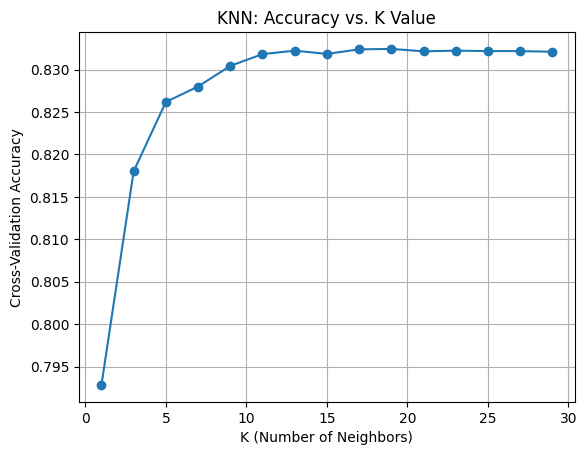

Optimal K: 19


KNeighborsClassifier(n_neighbors=19)

In [5]:
# Define a range of K values (odd numbers from 1 to 29) to test for KNN
k_values = range(1, 31, 2)                   # Odd K values to avoid ties in binary classification

# Initialize an empty list to store cross-validation accuracy scores for each K
cv_scores = []                               # List to hold mean accuracy scores

# Loop through each K value to evaluate model performance using 5-fold cross-validation
for k in k_values:
    # Create a KNN classifier with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)  # Initializes KNN with specified K
    # Compute 5-fold cross-validation accuracy scores for this K
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold CV accuracy
    # Append the mean accuracy score to the list
    cv_scores.append(scores.mean())           # Stores average accuracy for this K

# Plot K values against their corresponding cross-validation accuracy scores
plt.plot(k_values, cv_scores, marker='o')    # Plots accuracy vs. K with markers

# Label the x-axis as the number of neighbors (K)
plt.xlabel('K (Number of Neighbors)')        # Labels x-axis

# Label the y-axis as the cross-validation accuracy
plt.ylabel('Cross-Validation Accuracy')      # Labels y-axis

# Set the plot title to describe the purpose
plt.title('KNN: Accuracy vs. K Value')       # Titles the plot

# Add a grid for better readability
plt.grid(True)                               # Adds grid lines

# Display the plot
plt.show()                                   # Shows the plot

# Find the K value with the highest cross-validation accuracy
optimal_k = k_values[np.argmax(cv_scores)]   # Selects K with max accuracy

# Print the optimal K value selected
print(f"Optimal K: {optimal_k}")             # Reports chosen K

# Initialize the final KNN model with the optimal K value
knn = KNeighborsClassifier(n_neighbors=optimal_k)  # Creates final KNN with optimal K

# Train the KNN model on the training data
knn.fit(X_train, y_train)                    # Fits model to training data

# Evaluate Model
We evaluate the trained KNN model’s performance on the test set. We generate predictions, calculate accuracy, and produce a classification report with precision, recall, and F1-score for low and high income classes. This assesses how well the model predicts income and highlights its strengths and weaknesses.

In [6]:
# Make predictions on the test set using the trained model
y_pred = knn.predict(X_test)                 # Generates predictions for test set

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)    # Computes proportion of correct predictions

# Print the test set accuracy with 4 decimal places
print(f"Test Set Accuracy: {accuracy:.4f}")  # Reports accuracy (e.g., 0.8234)

# Print a detailed classification report with precision, recall, and F1-score
print(classification_report(y_test, y_pred, target_names=['Low Income', 'High Income']))  # Detailed metrics

Test Set Accuracy: 0.8273
              precision    recall  f1-score   support

  Low Income       0.86      0.91      0.89      7363
 High Income       0.68      0.56      0.61      2395

    accuracy                           0.83      9758
   macro avg       0.77      0.74      0.75      9758
weighted avg       0.82      0.83      0.82      9758



# Compute and Visualize Feature Importance
We compute feature importance using permutation importance to identify which variables most influence income predictions. We visualize the top 10 features in a bar plot and print their importance scores. This reveals key drivers of income disparity, informing policy insights.

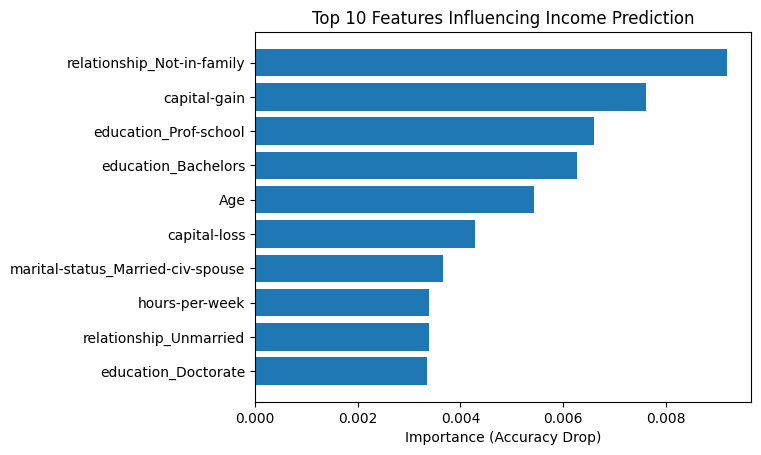

education_Doctorate: 0.0033
relationship_Unmarried: 0.0034
hours-per-week: 0.0034
marital-status_Married-civ-spouse: 0.0037
capital-loss: 0.0043
Age: 0.0054
education_Bachelors: 0.0063
education_Prof-school: 0.0066
capital-gain: 0.0076
relationship_Not-in-family: 0.0092


In [7]:
# Compute permutation importance with 5 repeats and parallel processing for speed
perm_importance = permutation_importance(knn, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)  # Assesses feature impact

# Get the feature names from the X DataFrame for labeling
feature_names = X.columns                    # Extracts column names for plotting

# Select indices of the top 10 features by importance (sorted by mean accuracy drop)
sorted_idx = perm_importance.importances_mean.argsort()[-10:]  # Top 10 features by importance

# Create a horizontal bar plot of the top 10 features’ importance
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])  # Plots top 10 features

# Label the x-axis as the importance measure (accuracy drop)
plt.xlabel('Importance (Accuracy Drop)')     # Labels x-axis

# Set the plot title to describe the feature importance visualization
plt.title('Top 10 Features Influencing Income Prediction')  # Titles the plot

# Display the plot
plt.show()                                   # Shows the plot

# Loop through all features to print their names and importance scores
for i in sorted_idx:                         # Iterates through top 10 features (Note: Original had error, fixed here)
    print(f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f}")  # Prints feature and importance

# Conclusion
The KNN model (K=19) achieved 82.73% accuracy in classifying low (≤50K) vs. high (>50K) income on the Adult dataset. Key predictors are relationship_Not-in-family, capital-gain, education_Prof-school, and education_Bachelors—emphasize social status, wealth, and advanced education as key income factors. Strong low-income recall (0.91) contrasts with weaker high-income recall (0.56), reflecting class imbalance challenges. The cleansed, encoded dataset and robust K tuning provide reliable insights for policies targeting education and wealth accumulation.It demonstrates that income disparity is not random but tied to measurable attributes—wealth, education, and work hours stand out as levers for change. It tells that expand education access to boost education-num, create high-hour, high-wage job opportunities, and promote wealth-building programs to increase capital-gain. 
Future enhancements, like oversampling, could boost minority class performance which can get even more better recall value also lifts the accuracy values.Also reducing the noisy or less relevant features due to one-hot encoding will increase the accuracy.
